In [1]:
import copy
import math
import matplotlib.pyplot as plt
import os
import re
import subprocess
import sys
import pandas as pd
import pickle
import time

from ast import literal_eval
from matplotlib.ticker import FuncFormatter
from IPython.display import display, clear_output
import matplotlib.ticker as ticker

# to do
# 1. add -d ' ' to gufi_query so it uses space as delimiter
# 2. don't convert ranges to human-friendly until plot time; then remove the stupid code we added to revert them back
# 3. instead of just showing some mean values as a function of depth, try to show distributions at each depth
#    this might be something like one graph per file-system with a different line per depth or something like that
# 4. make the cumulative graphs for the depths

In [2]:
# pull in our gquery module and import the config
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/jbent_home'
#os.environ['GUFI_DEBUG']='TRUE'
import gufi_config as gq
import gufi_common as gc

config = open(os.environ['GUFI_CONFIG'], 'r')
config=gq.Server(config)

nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
print(f"Using {nthreads} threads on {indexroot}")

indexroots = ["/mnt/nvme3n1/jbent/scr4/", 
              "/mnt/nvme3n1/jbent/yellprojs/", 
              "/mnt/nvme3n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme3n1/jbent/anony"]
testir = '/mnt/nvme3n1/jbent/jbent_home/'
data_pickle='all_data.pkl'

Using 224 threads on /mnt/nvme3n1/jbent/jbent_home


In [3]:
def run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose=False):
    cmd = 'gufi_query'
    command = [
        cmd,
        "-I", create_int,
        "-S", insert_int,
        "-K", create_agg,
        "-J", insert_agg,
        "-G", select_agg,
        "-n", nthreads,
        '-d', ' ',
        indexroot
    ]
    if Verbose:
        gc.print_query(command)
    
    start_time = time.time()
    completed_process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()
    
    if completed_process.returncode != 0:
        print(f"An error occurred:\n{completed_process.stderr.decode('utf-8')}")
        return None
    else:
        output = completed_process.stdout.decode('utf-8')
        output = output.replace('\u001A', ' ') # some weird character in the output for some reason

        if Verbose:
            #print(f"Output:\n{output}")
            print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")
        return output

In [4]:
# helper functions for converts the bins queries from sequel into human readable without any gaps
def detect_and_fill_missing_bins(series):
    lines = series.split('\n')
    new_lines = []
    last_upper = None

    for line in lines:
        match = re.match(r'\[(\d+),(\d+)\)', line)
        if match:
            lower, upper = map(int, match.groups())

            if last_upper is not None and lower != last_upper:
                missing_lower = last_upper
                missing_upper = lower
                new_line = f"[{missing_lower},{missing_upper}) 0"
                new_lines.append(new_line)

            new_lines.append(line)
            last_upper = upper

    return "\n".join(new_lines)

def human_readable_size(size, base, decimal_places=1):
    if float(size) == 0:
        return "0"

    if float(size) < 0:
        return f"size"
    
    if base == 1024:
        units = ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']
    else:
        units = ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']

    exponent = int(math.log(size, base))
    unit = units[exponent]
    size /= (base ** exponent)

    if size.is_integer():
        return f"{int(size)}{unit}"
    else:
        return f"{size:.{decimal_places}f}{unit}"
  
 
def human_readable_tic_marks(s):
    ret = re.sub(r'(\d+(\.\d+)?)', lambda m: str(human_readable_size(float(m.group(1)),base=1024)), s)
    #print(f"Converted {s} into {ret}")
    return ret

In [5]:
# function to query and return bins (based on logic in get_stats)
def get_bins(indexroot,field,entry_type,base,conversion,Verbose=True):
    cmd   = 'gufi_query'
    tab   = 'vrsummary'
    itab  = 'intermediate'
    atab  = 'aggregate'
    if entry_type == 'd':
        tab = 'vrsummary'
    elif entry_type == 'f':
        tab = 'vrpentries'
    else:
        print(f'ERROR: Unknown entry_type {entry_type}')
        return None
    
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = f"{nthreads}",
        create_int = f"CREATE TABLE {itab} (exponent INTEGER)",
        insert_int = f"INSERT INTO {itab} SELECT CASE WHEN {field} == 0 THEN -1 ELSE CAST(FLOOR(LOG({base}, {field})) AS INTEGER) END FROM {tab} WHERE (type == '{entry_type}')",
        create_agg = f"CREATE TABLE {atab} (exponent INTEGER, count INTEGER)",
        insert_agg = f"INSERT INTO {atab} SELECT exponent, count(exponent) FROM {itab} GROUP by exponent",
        select_agg = f"SELECT CASE WHEN exponent == -1 THEN '[0,1)' ELSE '[' || CAST(pow({base}, exponent) AS INTEGER) || ',' || CAST(pow({base}, exponent+1) AS INTEGER) || ')' END, SUM(count) FROM {atab} GROUP BY exponent ORDER BY exponent ASC",
        Verbose    = Verbose
    )
    output = detect_and_fill_missing_bins(output)
    #output = human_readable_bins(output,conversion)
    return(output)

def fetch_and_store_bin_data(ir,all_data,entry_type,field,base,conversion,Verbose):
    if field not in all_data:
        all_data[field] = {}
    if ir in all_data[field]:
        print(f"Cowardly refusing to refetch data for {ir}:{field}")
    else:
        all_data[field][ir] = get_bins(ir,field,entry_type,base,conversion,Verbose)

In [6]:
# function to query and return files per dir and bytes per file as a function of depth
def get_depths(indexroot,Verbose=True):
    cmd  = 'gufi_query'
    itab = 'intermediate'
    atab = 'aggregate'
    
    cstr = '(depth INTEGER, totfiles INTEGER, totsize INTEGER, totdirs INTEGERS)'
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = f"{nthreads}",
        create_int = f"CREATE TABLE {itab} {cstr}",
        insert_int = f"INSERT INTO {itab} SELECT level(), totfiles, totsize, 1 FROM vrsummary",
        create_agg = f"CREATE TABLE {atab} {cstr}",
        insert_agg = f"INSERT INTO {atab} SELECT * FROM {itab}",
        select_agg = f"SELECT depth, total(totdirs), total(totfiles), total(totsize),"
                  +  f" CASE WHEN total(totdirs)  = 0 THEN 0 ELSE total(totfiles)/total(totdirs)  END as filesperdir,"
                  +  f" CASE WHEN total(totfiles) = 0 THEN 0 ELSE total(totsize) /total(totfiles) END as bytesperfile"
                  +  f" FROM {atab} GROUP BY depth ORDER BY depth ASC",
        Verbose    = Verbose
    )
    return(output)

def fetch_and_store_depths(ir,all_data,Verbose):
    field = 'depths'
    if field not in all_data:
        all_data[field] = {}
    if ir in all_data[field]:
        print(f"Cowardly refusing to refetch data for {ir}:{field}")
    else:
        all_data[field][ir] = get_depths(ir,Verbose)

In [7]:
# let's start collecting data
# set up the structure where we store collected data
if 'all_data' not in locals():
    try:
        all_data = pickle.load(open(data_pickle, "rb"))
        print(f"Loaded from pickle at {data_pickle}")
    except FileNotFoundError:
        all_data = {}
Verbose=True
    
# fetch the bin data
target_bin_fields = [ ['totfiles', 'd',  2, 1024],
                      ['size',     'f',  2, 1024],
                    ]
for tbf in target_bin_fields:
    field, entry_type, base, conversion = tbf
    for ir in indexroots:
        fetch_and_store_bin_data(ir, all_data, field=field, entry_type = entry_type, base=base, conversion=conversion, Verbose=Verbose)
        
# now fetch the depth data
depth_columns = ['Depth', 'Total Directories', 'Total Files', 'Total Bytes', 
                  'Mean Files per Directory', 'Mean Bytes per File'
                 ]
for ir in indexroots:
    fetch_and_store_depths(ir,all_data,Verbose)        

Loaded from pickle at all_data.pkl
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/scr4/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellprojs/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/ttscratch/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellusers:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/anony:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/scr4/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellprojs/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/ttscratch/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellusers:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/anony:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/scr4/:depths
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellprojs/:depths
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/ttscratch/:depths
Cowardly refusing

In [14]:
def add_cumulative_columns(df,input_col,bucket=None,prefix=None): 
    # let's add some cumulative columns
    if prefix:
        prefix += " " # add a space
    else:
        prefix = '' # be empty
    cc = f'{prefix}Cumulative Count' # {input_col}'
    cd = f'{prefix}Cumulative Distribution' # {input_col}'
    pt = f'{prefix}Percent of Total' # {input_col}'
    cp = f'{prefix}Cumulative Percent of Total' # {input_col}'
    df[cc] = df[input_col].cumsum()
    total_count = df[input_col].sum()
    df[cd] = df[cc] / total_count
    if bucket:
        # add some more cumulative columns. Should work for files per dir and bytes per file. Not sure beyond that.
        df['Lower'] = df[bucket].apply(lambda x: int(x[1:x.index(',')]))
        df['Upper'] = df[bucket].apply(lambda x: int(x[x.index(',') + 1:-1]))

        # Calculating average size within each bin. Assume items are evenly distributed.
        df['AvgValue'] = (df['Lower'] + df['Upper'] - 1) / 2
        # Calculating quantity in each bucket and total quantity
        df['AggregateValue'] = df[input_col] * df['AvgValue']
        total_value = df['AggregateValue'].sum()
        # Calculating percent of all within each bin
        df[pt] = (df['AggregateValue'] / total_value) * 100
        df[cp] = df[pt].cumsum()
    return df

In [9]:
def depths_to_dataframes(all_data,dataframes,depth_columns):
    for ir,depths in all_data['depths'].items():
        #print(ir,len(depths),type(depths))
        data = { column : [] for column in depth_columns }
        next_row = 0
        for line in depths.split('\n'):
            if not line.strip():
                continue # skip blank lines which might be at the end
            #print(f"processing {line} in {ir}")
            tokens = line.split()
            while(int(tokens[0]) != next_row): # fill any gaps in the data with zeros. But it's weird. 
                print(f"WARN: {ir} somehow has nothing at depth {next_row}")
                for v in data.values():
                    v.append(0)
                next_row += 1
            for i,(k,v) in enumerate(data.items()):
                v.append(float(tokens[i]))
            next_row += 1
        #print(data)
        df = pd.DataFrame(data)
        for col in depth_columns:
            if 'Total' in col:
                df = add_cumulative_columns(df,col,None,prefix=col)
        dataframes[ir] = df
    return dataframes
        
#[(v.split('\n')) for v in all_data['depths'].values()]
#sample = list(all_data['depths'].values())[0]
#[print(s) for s in sample.split('\n')]

# convert the depths raw data into dataframes suitable for plotting
depths_dataframes = {}
depths_to_dataframes(all_data,depths_dataframes,depth_columns)
pass
#depths_dataframes['/mnt/nvme3n1/jbent/anony']

WARN: /mnt/nvme3n1/jbent/yellprojs/ somehow has nothing at depth 0
WARN: /mnt/nvme3n1/jbent/yellprojs/ somehow has nothing at depth 1
WARN: /mnt/nvme3n1/jbent/yellprojs/ somehow has nothing at depth 2
WARN: /mnt/nvme3n1/jbent/ttscratch/ somehow has nothing at depth 0
WARN: /mnt/nvme3n1/jbent/ttscratch/ somehow has nothing at depth 1
WARN: /mnt/nvme3n1/jbent/yellusers somehow has nothing at depth 0
WARN: /mnt/nvme3n1/jbent/yellusers somehow has nothing at depth 1


In [10]:
# the function which actually turns a dict into a plot
# the dict should have keys pointing to dataframes and it draws a line for each using the key as the line label
def frames_to_plt(dataframes,xlabel,yvalue,logscale=False,xvalue='Bucket'):
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 16
    
    # first make sure our axes go to the max values
    max_x = max(df[xvalue].max() for df in dataframes.values())
    max_y = max(df[yvalue].max() for df in dataframes.values())
    try:
        plt.xlim(None, max_x * 1.1)
    except TypeError: # this only works for normal numbered x-tics but won't work for our range strings
        pass
    if not logscale:
        plt.ylim(None, max_y * 1.1) # if logscale, it looks crappy

    # Plot the data as a line graph
    markers = ['o', 'x', 's', 'D', '^', 'v']
    for idx, (indexroot, df) in enumerate(dataframes.items()):
        shortname = indexroot.rstrip('/').split("/")[-1]
        plt.plot(df[xvalue], df[yvalue], marker=markers[idx], label=shortname)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(yvalue)
    plt.title(f'{yvalue} at {xlabel}')

    # get the ax which we use for a bunch of manipulations below
    ax = plt.gca()
    
    # avoid transparent background
    for item in (ax.figure, ax):
        item.set_facecolor('white')
    
    # Get current xticks and manipulate them from the plot
    # first call draw to populate them
    plt.draw()
    xticks = ax.get_xticks()
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    #print(xticklabels)
    new_xtick_labels = [human_readable_tic_marks(str(x)) for x in xticklabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(new_xtick_labels)
    if len(xticks) > 20:
        new_xticks = xticks[::2]
        ax.set_xticks(new_xticks)
        
    # rotate and align the xticks
    plt.xticks(rotation=45, ha="right")

    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    if logscale:
        # then add logscale and show it again
        ax.set_yscale('symlog')
        plt.ylim(0,None)
        ax.set_title(ax.get_title() + " (Log Scale y)")
        ax.set_ylabel(ax.get_ylabel() + " (Log Scale 10)")
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.yaxis.get_major_formatter().set_useOffset(False)
        
    # Get current yticks and manipulate them some
    yticks = ax.get_yticks()
    new_ytick_labels = [human_readable_size(size = float(y), base=1000, decimal_places=2) for y in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(new_ytick_labels)
        
    return plt

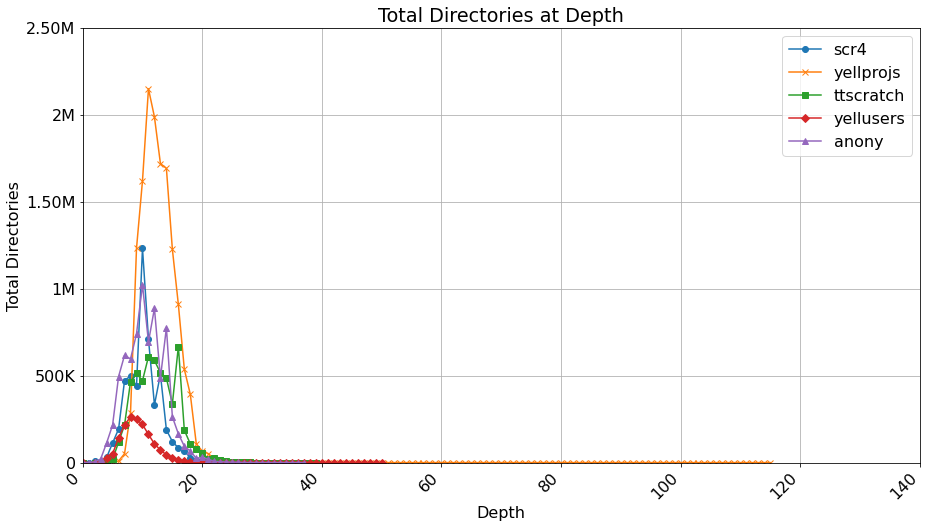

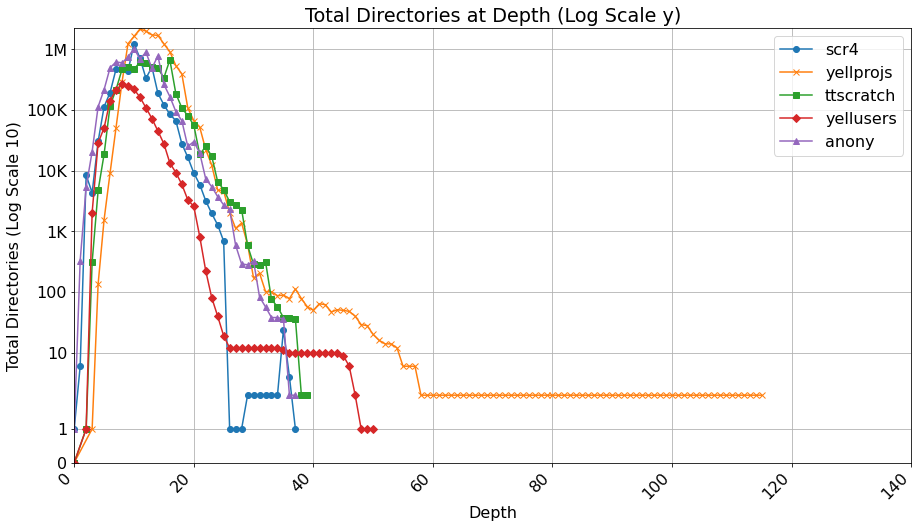

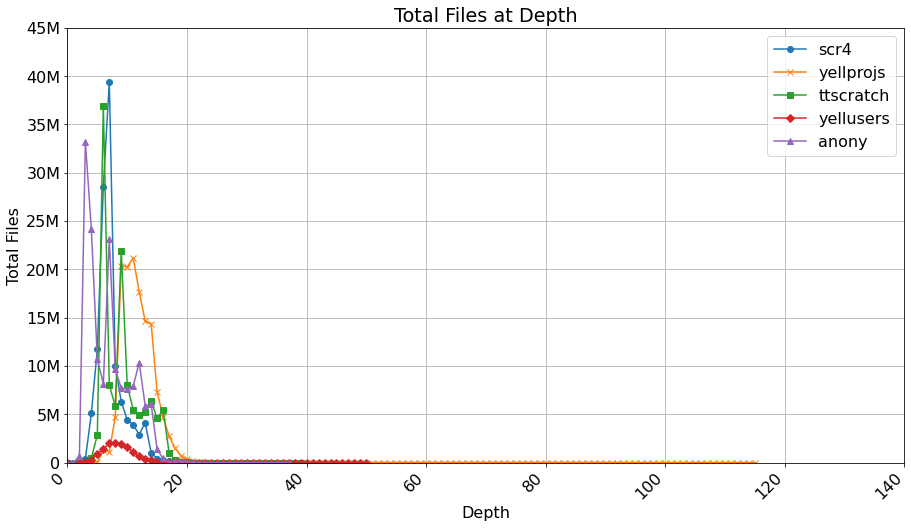

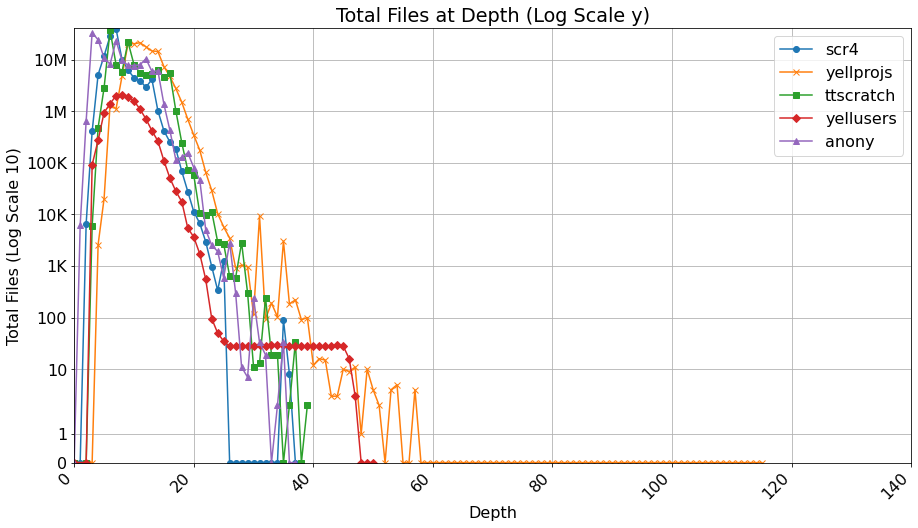

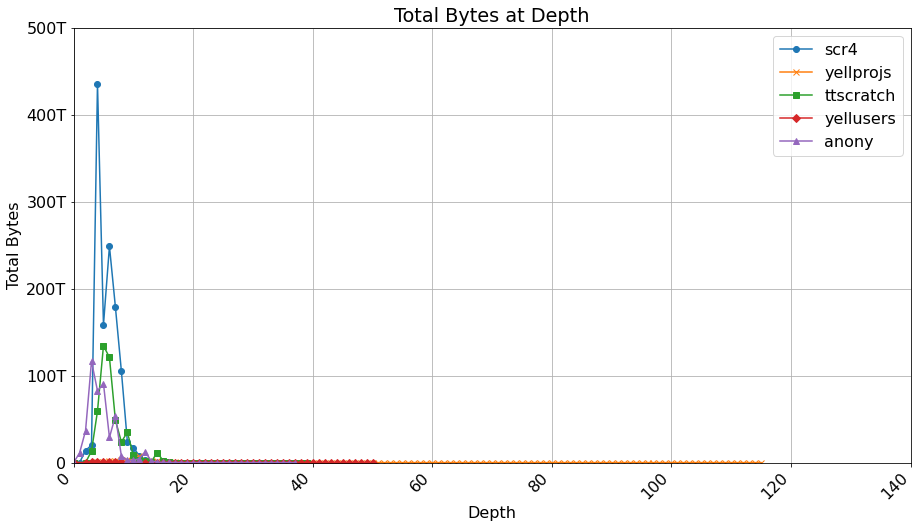

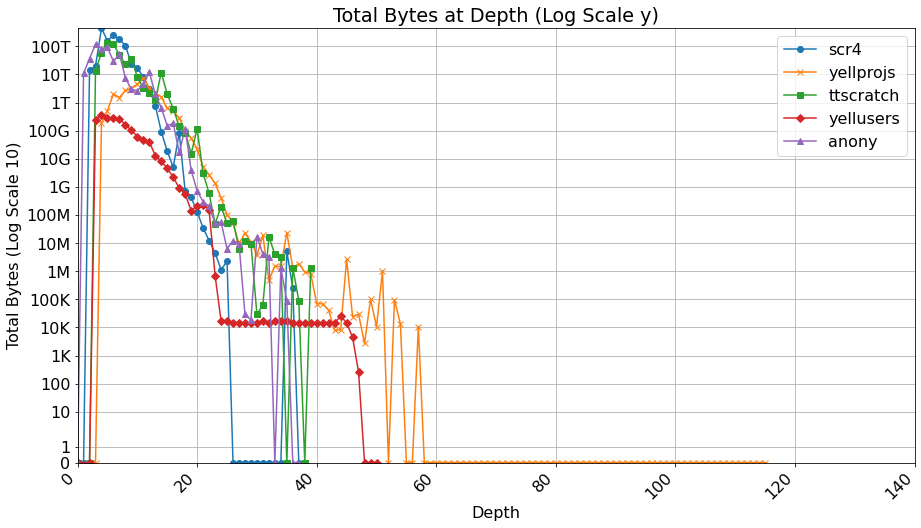

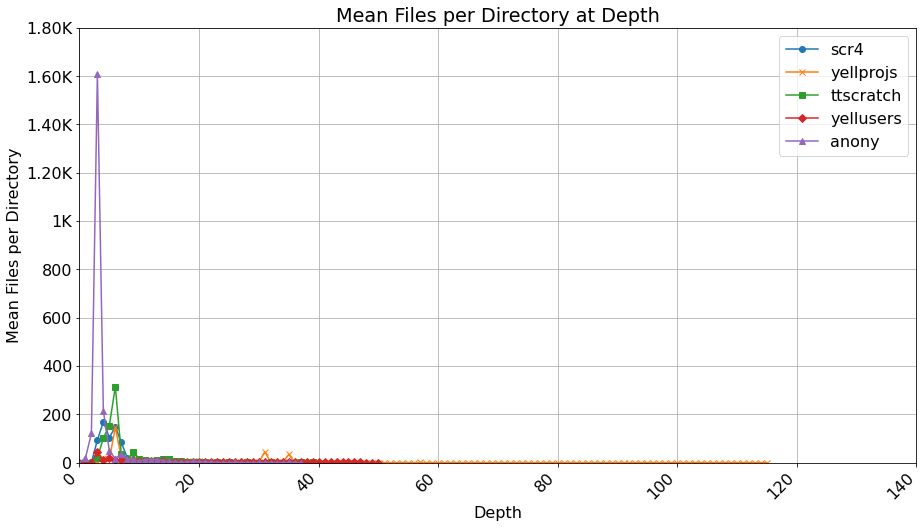

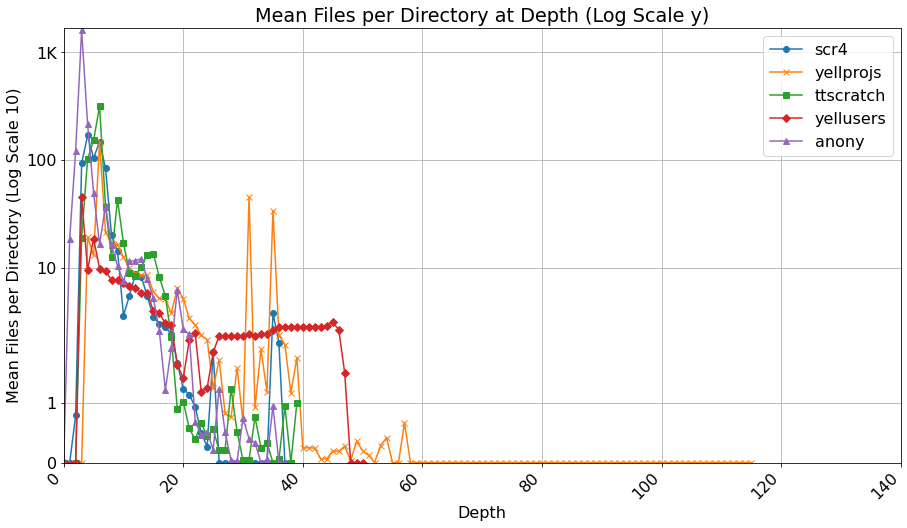

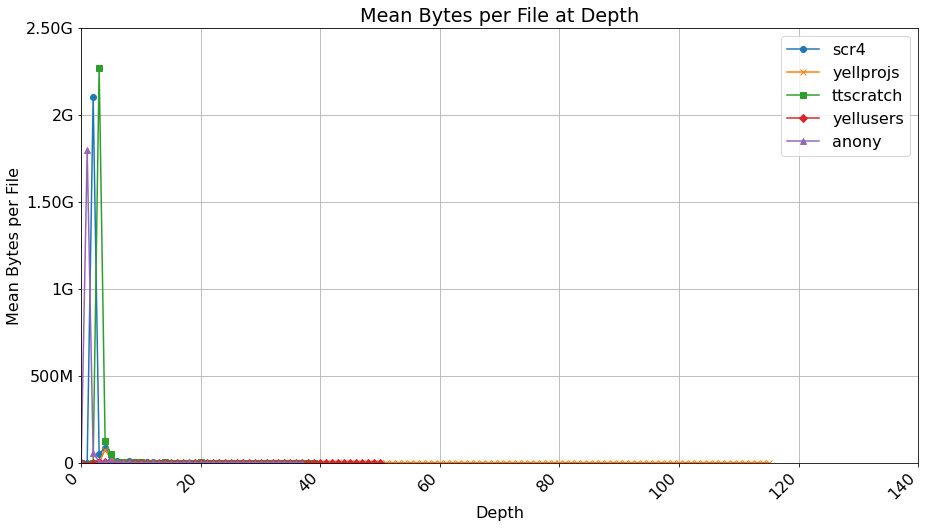

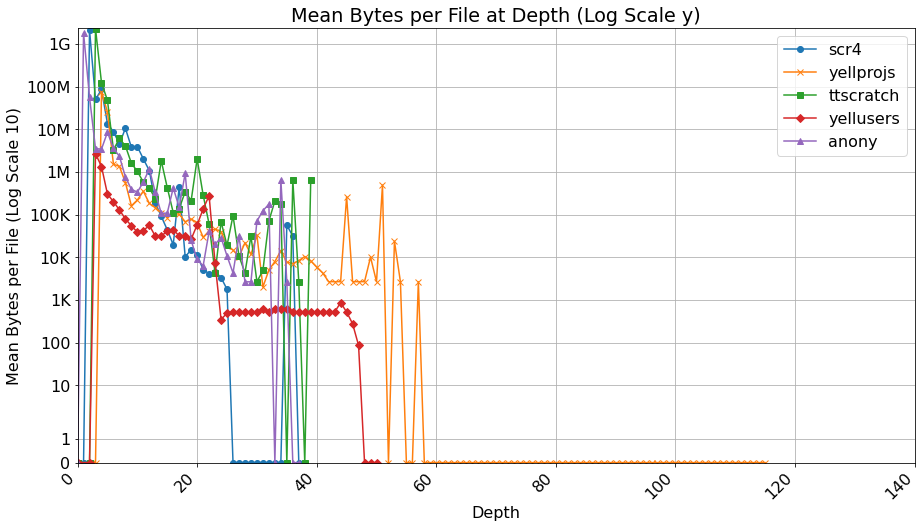

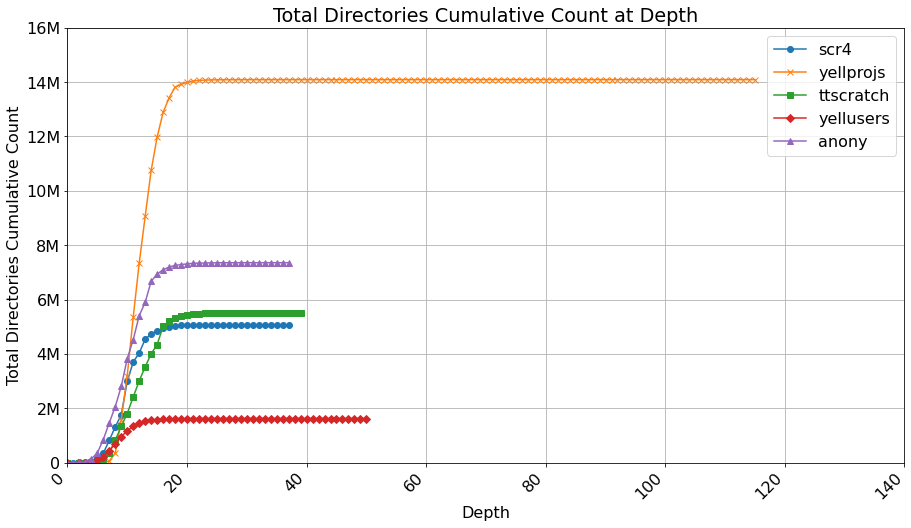

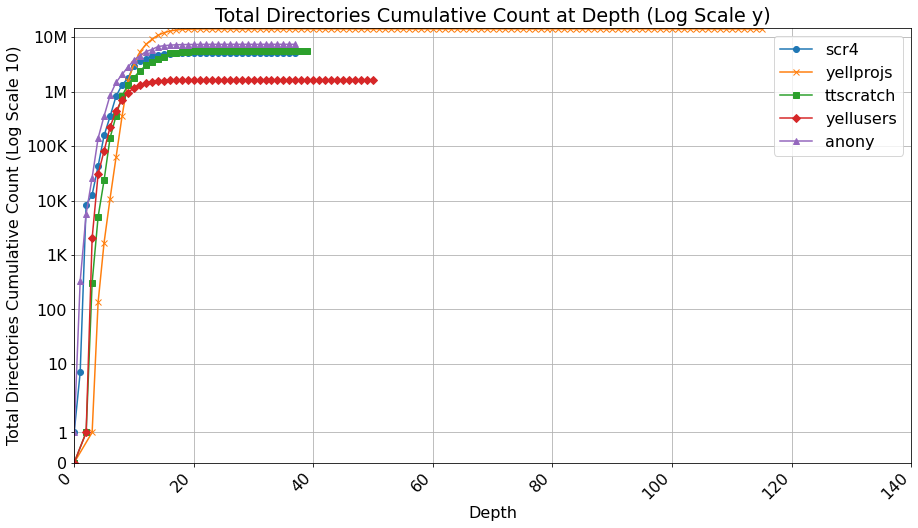

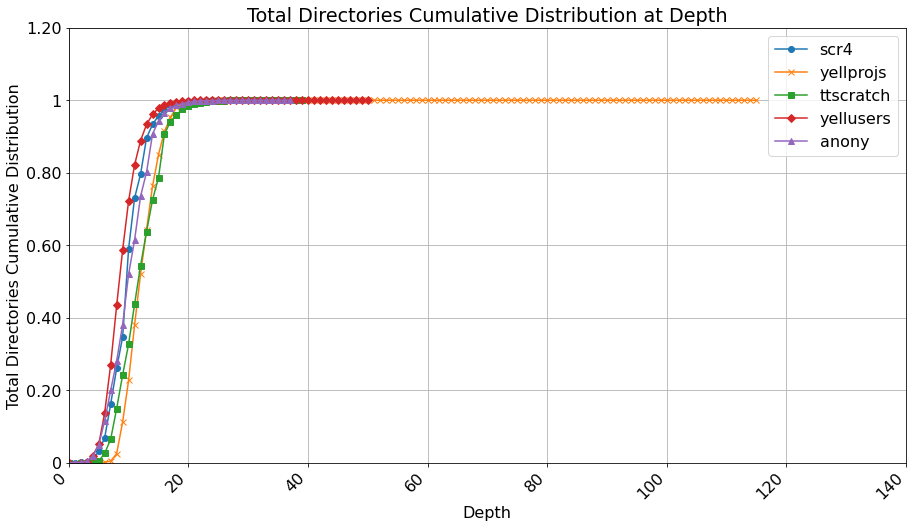

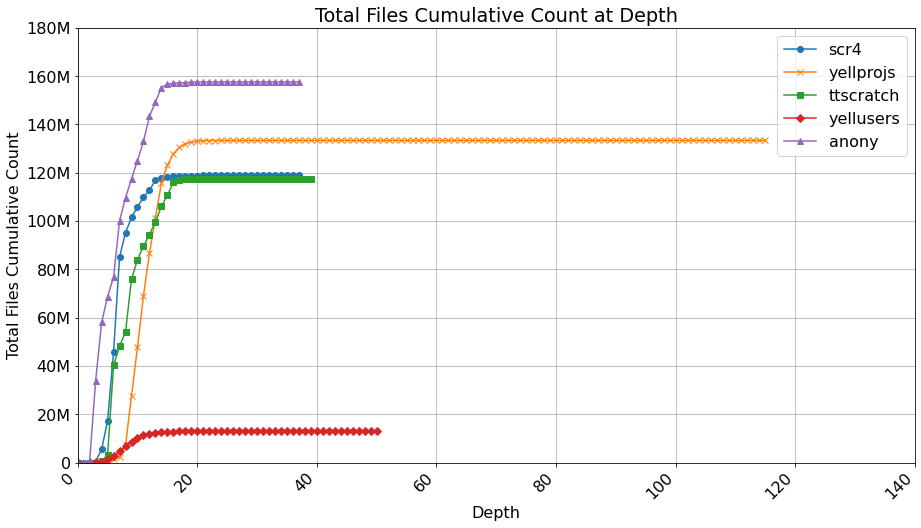

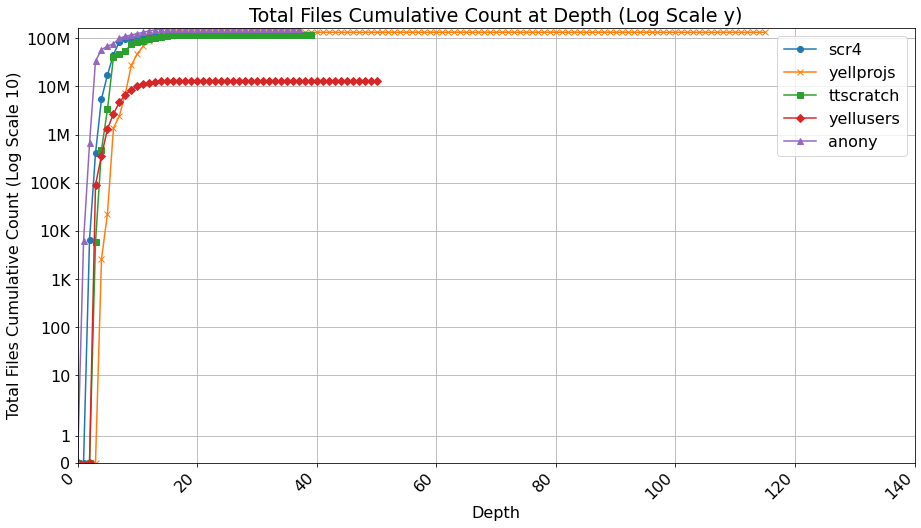

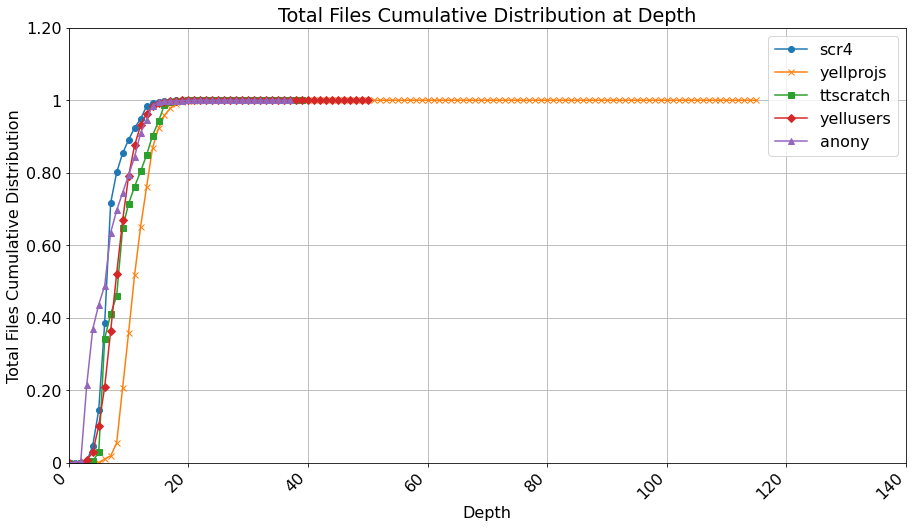

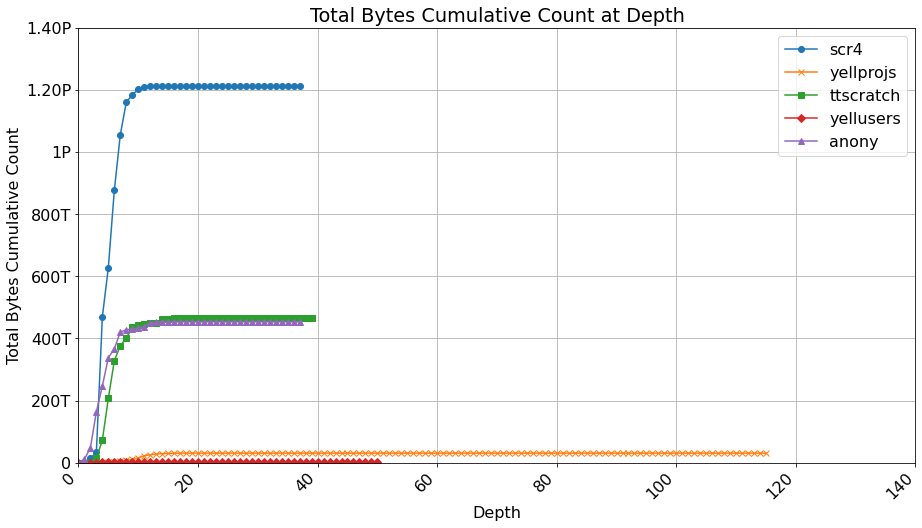

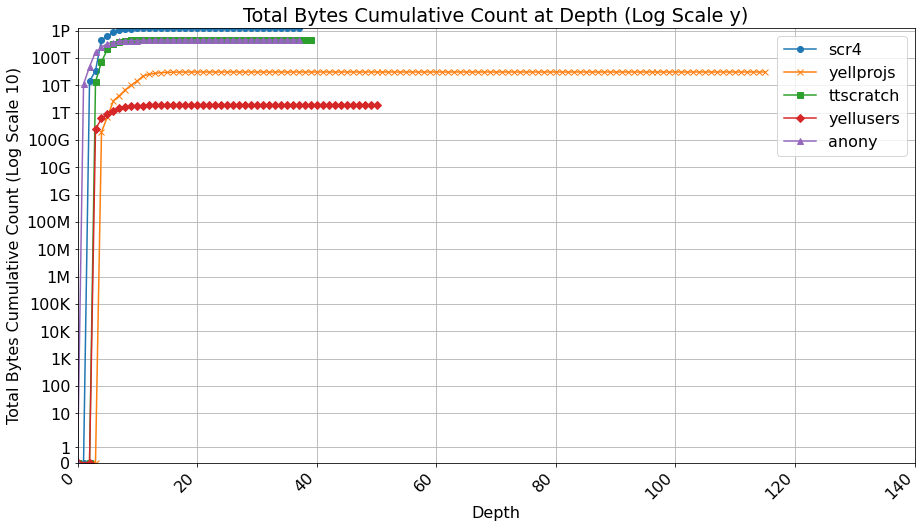

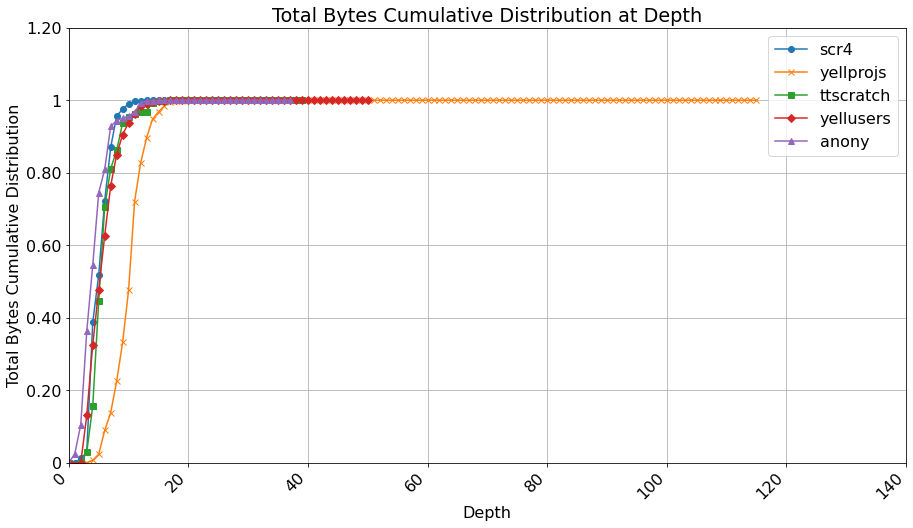

In [11]:
# now plot the depth dataframes
for dc in depths_dataframes[indexroots[0]].columns.tolist():
    if dc == 'Depth':
        continue
    plt = frames_to_plt(depths_dataframes,'Depth',dc,logscale=False, xvalue='Depth')
    plt.show()
    if 'Distribution' not in dc and 'Percent' not in dc:
        plt = frames_to_plt(depths_dataframes,'Depth',dc,logscale=True, xvalue='Depth')
        plt.show()

In [12]:
# convert the bin data into dataframes
def convert_log_bins_to_dataframes(log_bins):
    ub = 'Bucket'
    ni = 'Quantity'
    data = { ub : [], ni : []}
    for line in log_bins.split('\n'):
        try:
            tokens = line.replace('\x1E', ' ').split() # not sure where this weird character is coming from but split on it 
            data[ub].append(tokens[0])
            data[ni].append(int(tokens[1]))
        except:
            print(f"Warn: couldn't split {line}")
    df = pd.DataFrame(data)
    df = add_cumulative_columns(df,input_col=ni,bucket=ub)
    return df

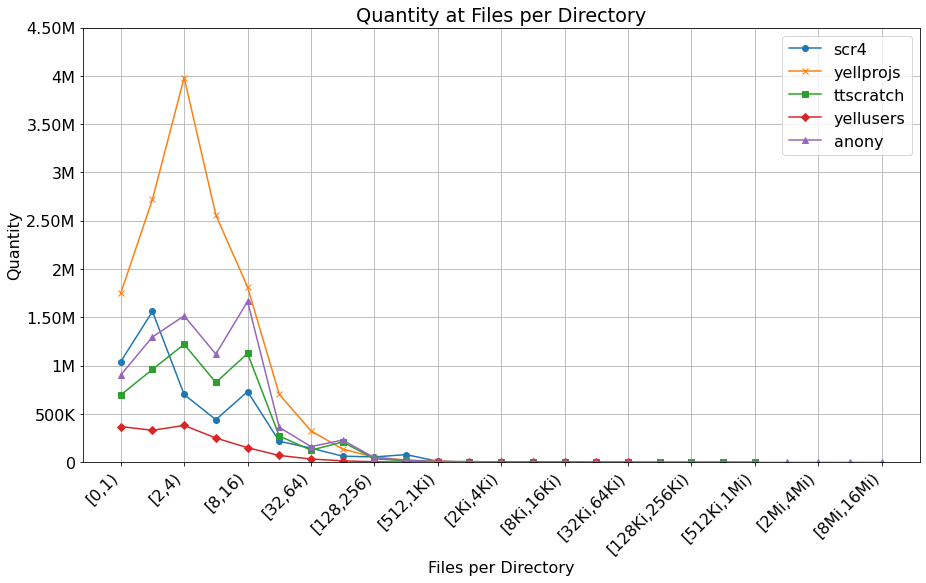

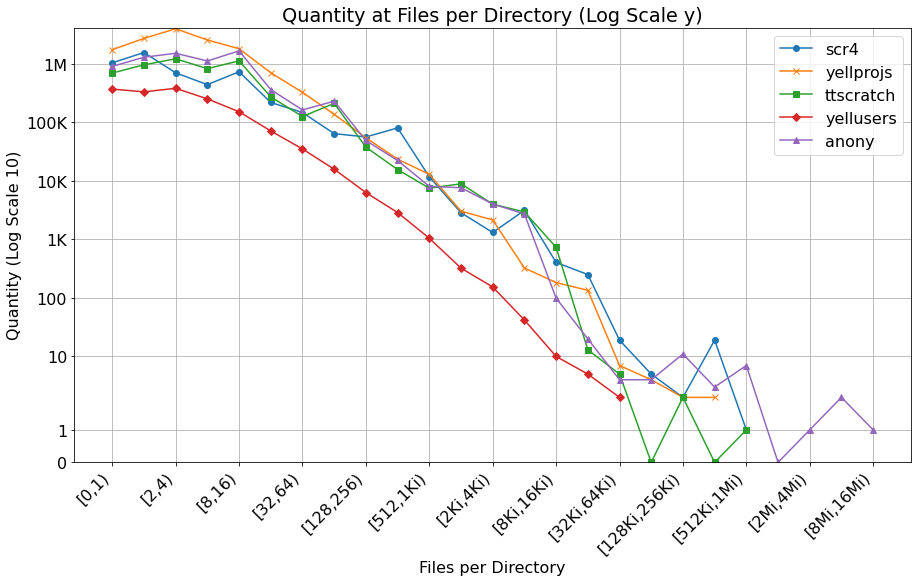

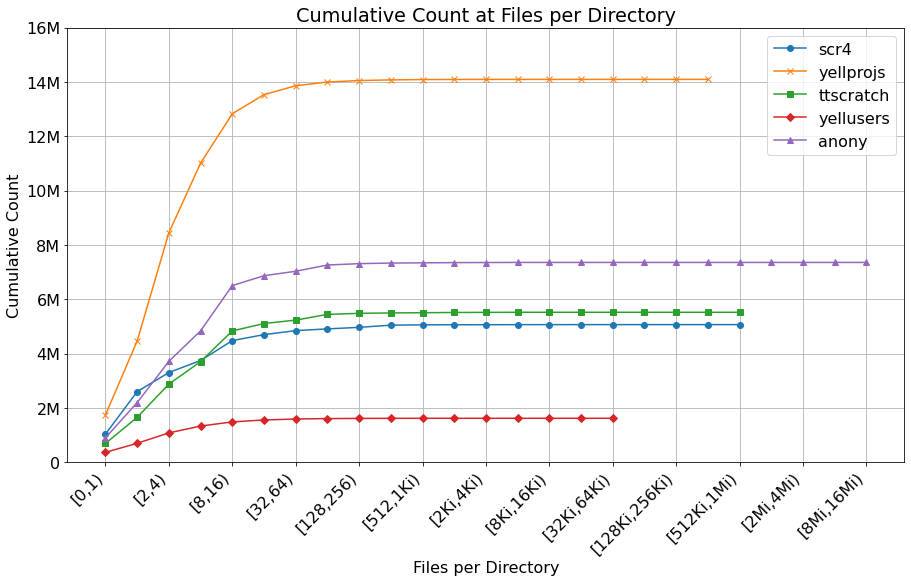

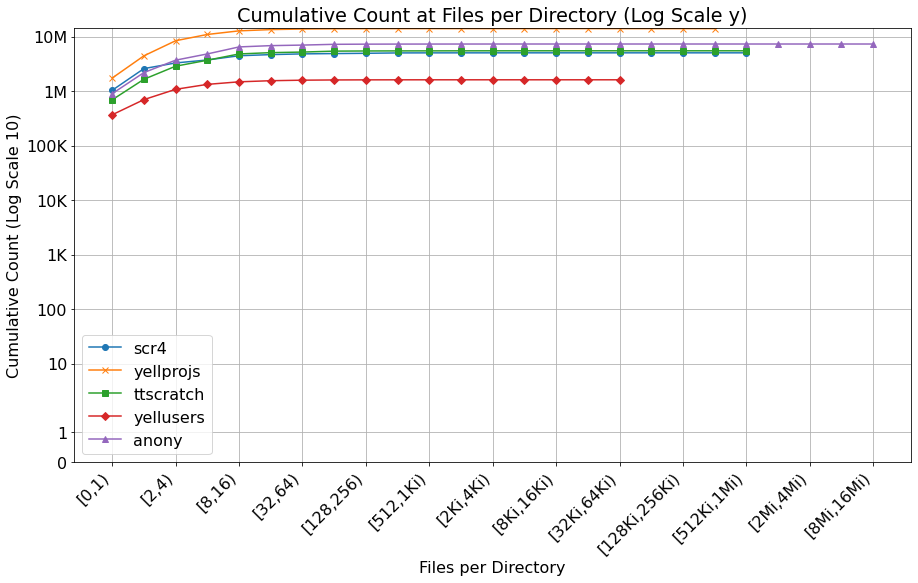

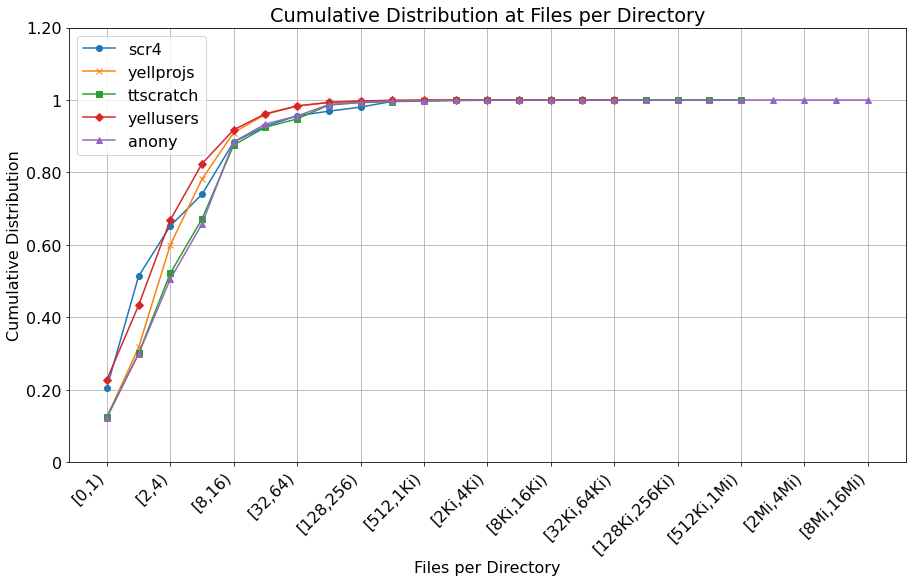

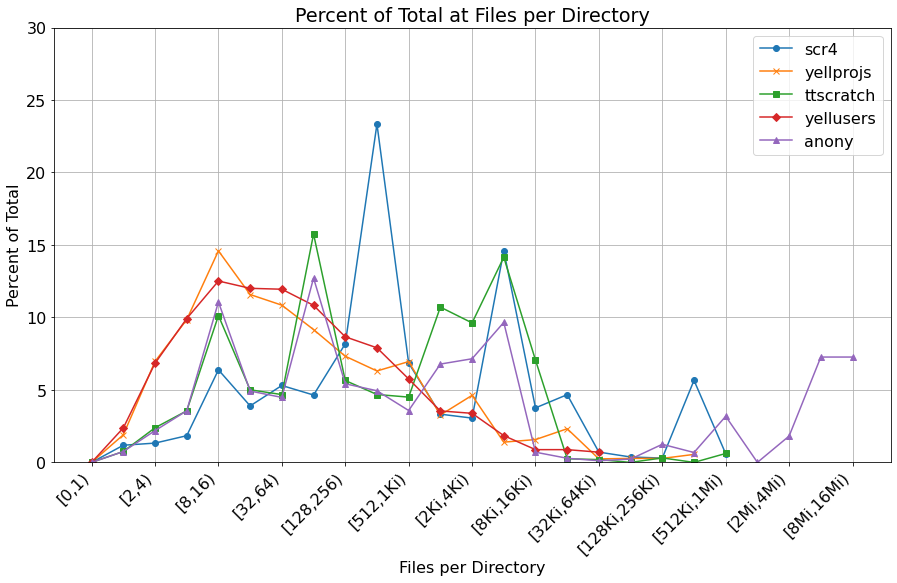

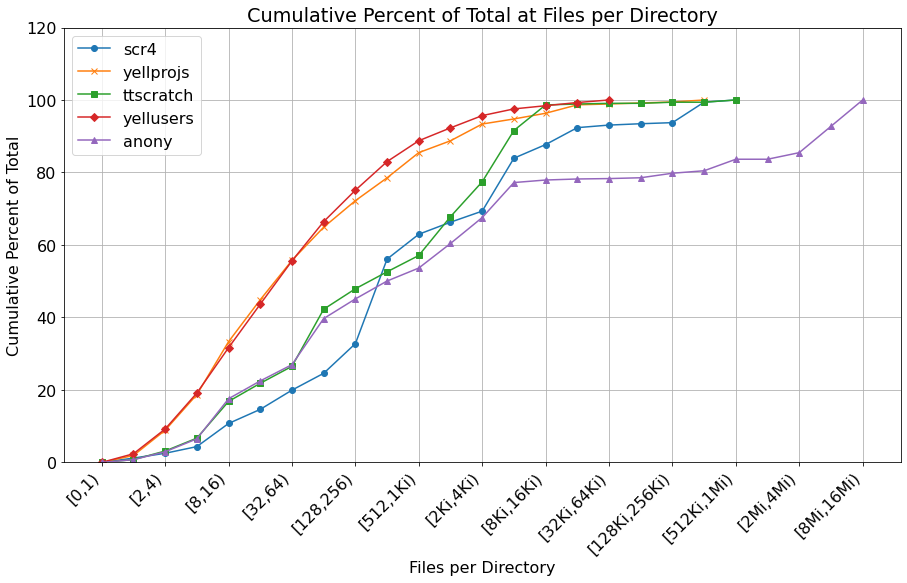

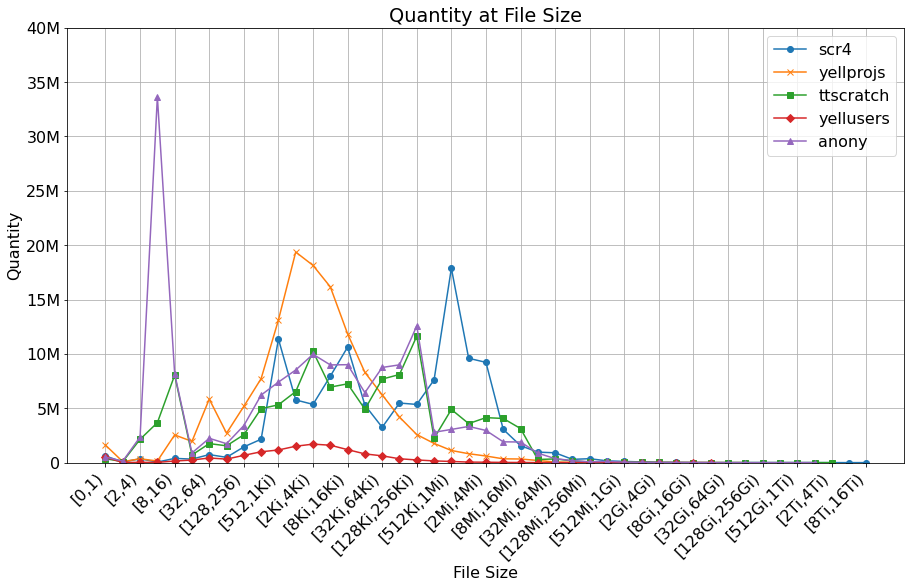

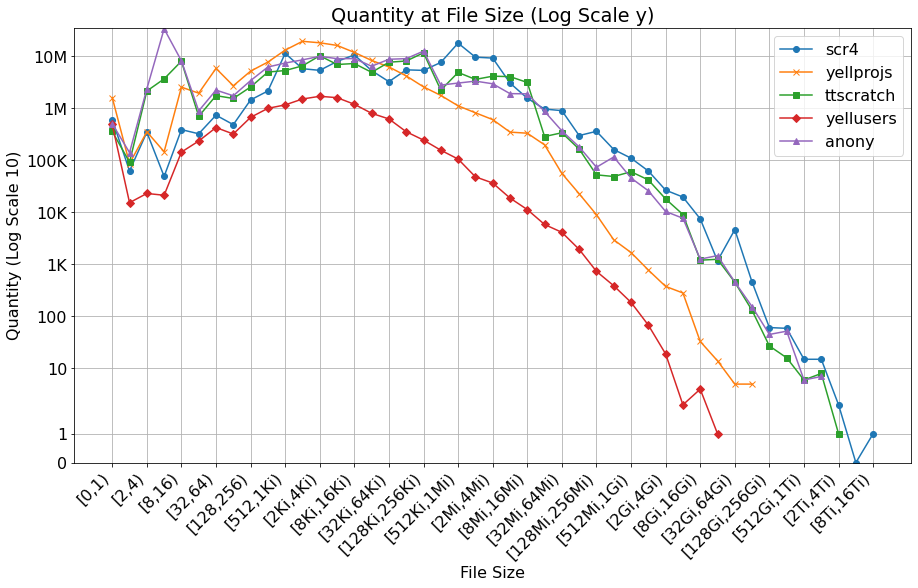

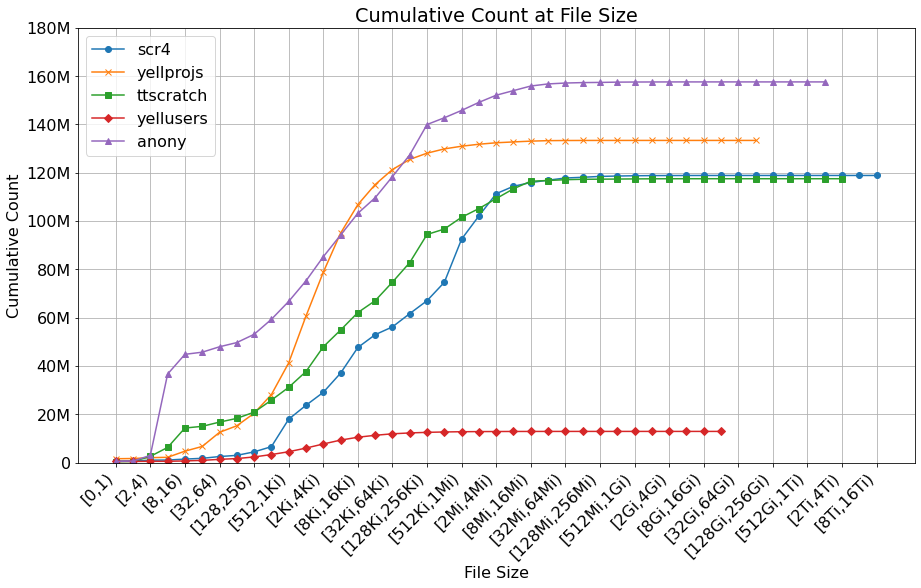

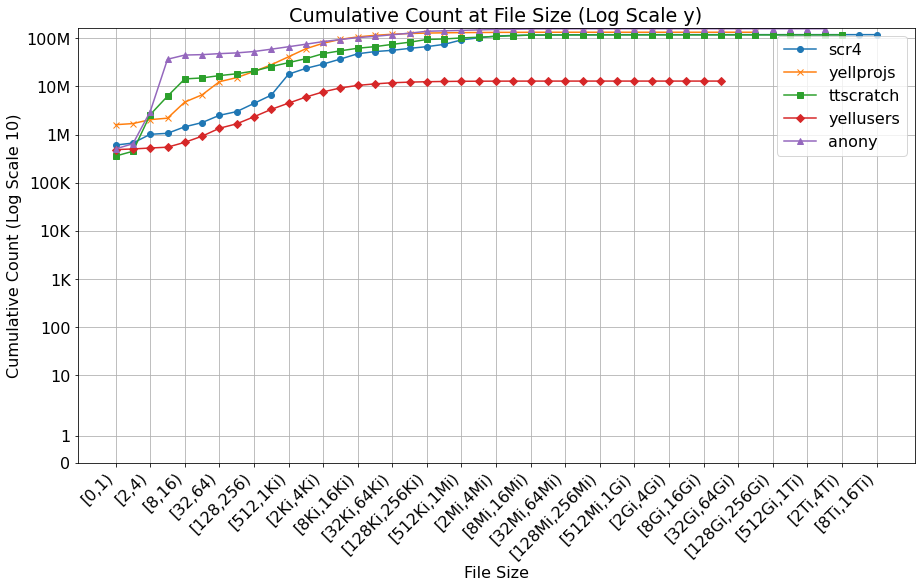

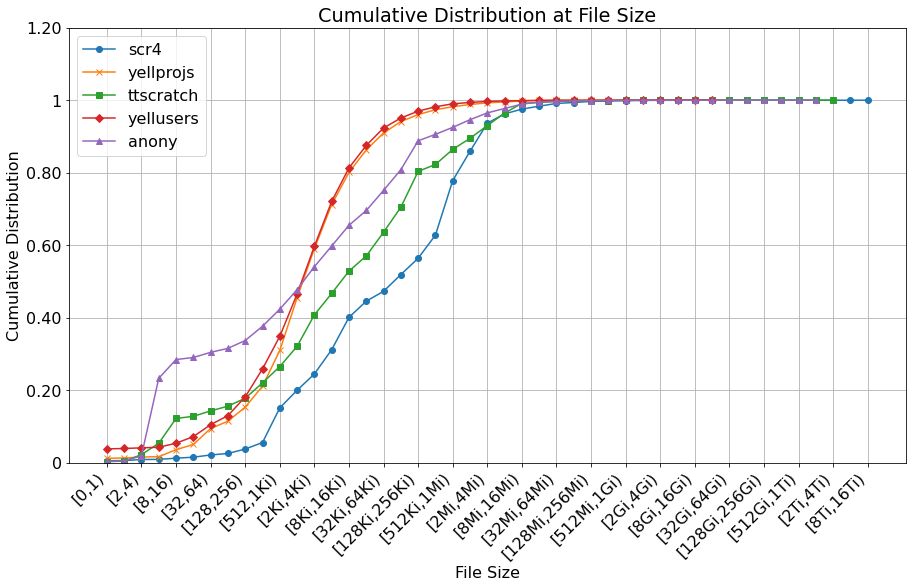

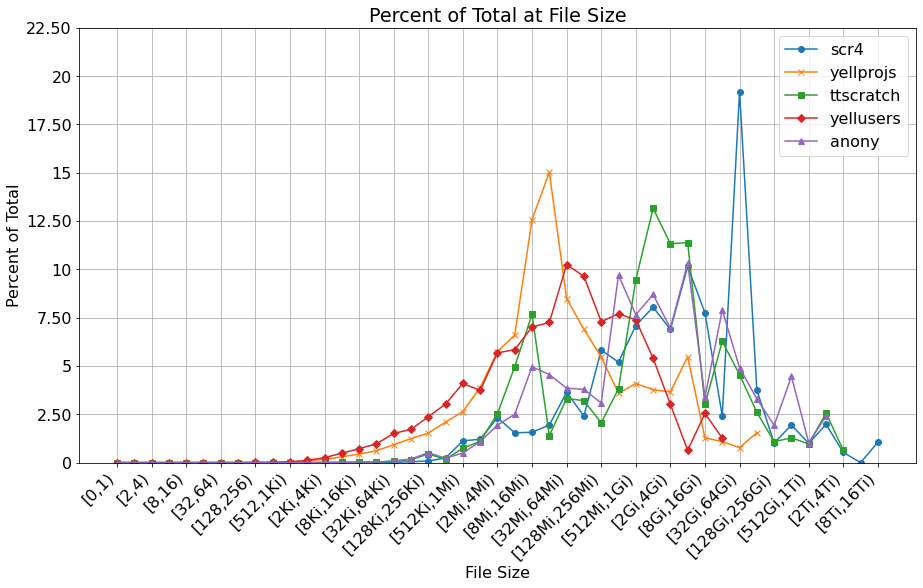

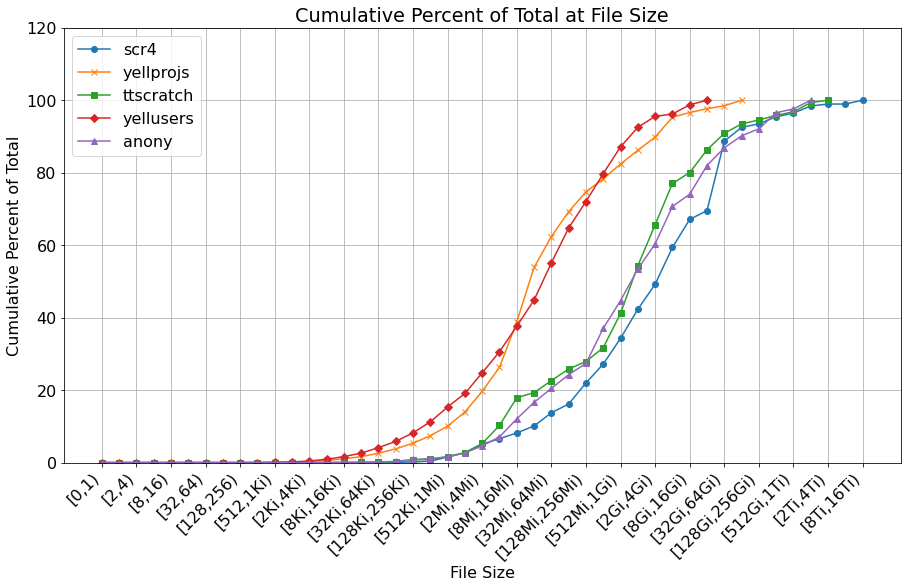

In [16]:
def make_bin_graphs(all_data, field, xlabel):    
    dataframes = {}
    for ir,data in all_data[field].items():
        #print(f"Trying to convert {ir}:totfiles:\n{data} into a df")
        dataframes[ir] = convert_log_bins_to_dataframes(data)
    for graph in ('Quantity', 'Cumulative Count', 'Cumulative Distribution', 'Percent of Total', 'Cumulative Percent of Total'):
        plt = frames_to_plt(dataframes, xlabel=xlabel,yvalue=graph,logscale=False,xvalue='Bucket')
        plt.show()
        if 'Distribution' not in graph and 'Percent' not in graph:
            plt = frames_to_plt(dataframes, xlabel=xlabel,yvalue=graph,logscale=True,xvalue='Bucket')
            plt.show()
    return dataframes

make_bin_graphs(all_data,'totfiles','Files per Directory')
make_bin_graphs(all_data,'size','File Size')
pass

In [ ]:
#print(df['/mnt/nvme3n1/jbent/scr4/'])
pickle.dump(all_data, open(data_pickle, "wb")) # save in a pickle in case we lose the jupyter server